# Wczytywanie bibliotek

In [347]:
import json 
import pandas as pd 
from pandas.io.json import json_normalize

# Czyszczenie danych i tworzenie zbiorów

In [348]:
# dodać liczbę obserwacji, sprawdzić braki w danych i duplikaty

In [349]:
dane = pd.read_json('./customers.txt', lines=True)

In [350]:
dane = pd.concat([dane.drop(['customer'], axis=1), dane['customer'].apply(pd.Series)], axis=1)

In [351]:
customers_df = dane.drop(columns=['orders', 'paymentMethods', 'transactions'])
customers_df['customer_id'] = range(0, len(customers_df['fraudulent']), 1)

In [352]:
customers_df.head()

,fraudulent,customerEmail,customerPhone,customerDevice,customerIPAddress,customerBillingAddress,customer_id
0,False,josephhoward@yahoo.com,400-108-5415,yyeiaxpltf82440jnb3v,8.129.104.40,"5493 Jones Islands\nBrownside, CA 51896",0
1,True,evansjeffery@yahoo.com,1-788-091-7546,r0jpm7xaeqqa3kr6mzum,219.173.211.202,"356 Elizabeth Inlet Suite 120\nPort Joshuabury, NM 37681",1
2,False,andersonwilliam@yahoo.com,024.420.0375,4m7h5ipl1shyavt6vv2r,67b7:3db8:67e0:3bea:b9d0:90c1:2b60:b9f0,"8478 Sean Ridges Apt. 441\nDavisberg, PR 72250",2
3,False,rubenjuarez@yahoo.com,670.664.8168x94985,slovx60t0i558may4ks0,95de:8565:5a66:792c:26e0:6cfb:7d87:11af,"7769 Elizabeth Bridge Apt. 343\nNortonstad, FM 51359",3
4,True,uchen@malone.com,1-981-877-0870,j0pd24k5h8dl2fqu0cz4,196.89.235.192,"148 Russell Lodge Apt. 445\nPort Jenniferside, TN 60556-0871",4


In [353]:
customers_df['strange_customerEmail'] = 0
customers_df['strange_paymentMethodIssuer'] = 0
customers_df['ipv4'] = 0
customers_df['ipv6'] = 0
customers_df['repeated_customerIPAddress'] = 0
customers_df['repeated_customerEmail'] = 0
customers_df['repeated_customerBillingAddress'] = 0

In [354]:
customers_df.loc[customers_df['customerEmail'].str.contains('\.') == False, 'strange_customerEmail'] = 1

In [355]:
customers_df.loc[customers_df['customerIPAddress'].str.contains('\.') == True, 'ipv4'] = 1

In [356]:
customers_df.loc[customers_df['customerIPAddress'].str.contains('\:') == True, 'ipv6'] = 1

In [357]:
customers_df[customers_df.duplicated(['customerIPAddress'])].drop_duplicates()['customerIPAddress']

80     45.203.99.249
88     45.203.99.249
141    45.203.99.249
Name: customerIPAddress, dtype: object

In [358]:
customers_df.loc[customers_df['customerIPAddress'].str.contains('45.203.99.249') == True, 'repeated_customerIPAddress'] = 1

In [359]:
customers_df[customers_df.duplicated(['customerEmail'])].drop_duplicates()['customerEmail']

40     johnlowery@gmail.com
45     johnlowery@gmail.com
65     johnlowery@gmail.com
79     johnlowery@gmail.com
133    johnlowery@gmail.com
155    johnlowery@gmail.com
165    johnlowery@gmail.com
Name: customerEmail, dtype: object

In [360]:
customers_df.loc[customers_df['customerEmail'].str.contains('johnlowery@gmail.com') == True, 'repeated_customerEmail'] = 1

In [361]:
customers_df[customers_df.duplicated(['customerBillingAddress'])].drop_duplicates()['customerBillingAddress'].tolist()[0]

'49680 Brian Squares Apt. 122\nPort Walterburgh, MH 02766-0708'

In [362]:
customers_df.loc[customers_df['customerBillingAddress'].str.contains('49680 Brian Squares Apt. 122\nPort Walterburgh, MH 02766-0708') == True, 'repeated_customerBillingAddress'] = 1

In [363]:
customers_df[customers_df.duplicated(['customerBillingAddress'])].drop_duplicates()

,fraudulent,customerEmail,customerPhone,customerDevice,customerIPAddress,customerBillingAddress,customer_id,strange_customerEmail,strange_paymentMethodIssuer,ipv4,ipv6,repeated_customerIPAddress,repeated_customerEmail,repeated_customerBillingAddress
80,True,warrenedward@arnold.com,201.737.5119x64000,6py7ewqjkxjw8zjl9eri,45.203.99.249,"49680 Brian Squares Apt. 122\nPort Walterburgh, MH 02766-0708",80,0,0,1,0,1,0,1
90,True,brittanydean@hotmail.com,06238721842,yq8xiivmx4prlgx0gofo,3517:8e52:885:8640:a59:f5fd:cb33:b06a,"49680 Brian Squares Apt. 122\nPort Walterburgh, MH 02766-0708",90,0,0,0,1,0,0,1


In [364]:
orders_df = pd.DataFrame()
paymentMethods_df = pd.DataFrame()
transactions_df = pd.DataFrame()

for single_customer in range(0, len(dane['orders']), 1):
    for order in dane['orders'][single_customer]:
        simple_df = pd.DataFrame([order])
        simple_df['customer_id'] = single_customer
        orders_df = orders_df.append(simple_df)
        
for single_customer in range(0, len(dane['paymentMethods']), 1):
    for paymentMethod in dane['paymentMethods'][single_customer]:
        simple_df = pd.DataFrame([paymentMethod])
        simple_df['customer_id'] = single_customer
        paymentMethods_df = paymentMethods_df.append(simple_df)
        
for single_customer in range(0, len(dane['transactions']), 1):
    for transaction in dane['transactions'][single_customer]:
        simple_df = pd.DataFrame([transaction])
        simple_df['customer_id'] = single_customer
        transactions_df = transactions_df.append(simple_df)

In [365]:
orders_df.head()

,orderAmount,orderId,orderShippingAddress,orderState,customer_id
0,18,vjbdvd,"5493 Jones Islands\nBrownside, CA 51896",pending,0
0,26,yp6x27,"5493 Jones Islands\nBrownside, CA 51896",fulfilled,0
0,45,nlghpa,"898 Henry Ports\nNew Keithview, CA 95893-2497",fulfilled,1
0,23,uw0eeb,"356 Elizabeth Inlet Suite 120\nPort Joshuabury, NM 37681",fulfilled,1
0,43,bn44oh,"5093 Bryan Forks\nJoshuaton, FM 01565-9801",fulfilled,1


In [366]:
paymentMethods_df.head()

,paymentMethodId,paymentMethodIssuer,paymentMethodProvider,paymentMethodRegistrationFailure,paymentMethodType,customer_id
0,wt07xm68b,Citizens First Banks,JCB 16 digit,True,card,0
0,y3xp697jx,Solace Banks,VISA 16 digit,True,bitcoin,1
0,6krszxc05,Vertex Bancorp,VISA 16 digit,False,card,1
0,5z1szj2he,His Majesty Bank Corp.,Diners Club / Carte Blanche,False,card,1
0,m52tx8e1s,Vertex Bancorp,Mastercard,False,card,1


In [367]:
transactions_df.head()

,orderId,paymentMethodId,transactionAmount,transactionFailed,transactionId,customer_id
0,vjbdvd,wt07xm68b,18,False,a9lcj51r,0
0,yp6x27,wt07xm68b,26,False,y4wcv03i,0
0,nlghpa,41ug157xz,45,False,5mi94sfw,1
0,uw0eeb,41ug157xz,23,False,br8ba1nu,1
0,bn44oh,y3xp697jx,43,True,a33145ss,1


# Cechy zbioru danych

In [368]:
print('Łączna liczba klientów: {}'.format(len(customers_df)))

Łączna liczba klientów: 168


In [369]:
print('Łączna liczba zamówień: {}'.format(len(orders_df)))

Łączna liczba zamówień: 478


In [370]:
print('Łączna liczba metod płatności: {}'.format(len(paymentMethods_df)))

Łączna liczba metod płatności: 342


In [371]:
print('Łączna liczba transakcji: {}'.format(len(transactions_df)))

Łączna liczba transakcji: 623


In [414]:
print('Liczba fraudów w zbiorze: {}'.format(customers_df['fraudulent'].sum()))

Liczba fraudów w zbiorze: 61


In [415]:
print('Liczba nie-fraudów w zbiorze: {}'.format(len(customers_df) - customers_df['fraudulent'].sum()))

Liczba nie-fraudów w zbiorze: 107


In [418]:
print('Procent fraudów w zbiorze: {}'.format(100*(customers_df['fraudulent'].sum() / len(customers_df))))

Procent fraudów w zbiorze: 36.30952380952381


In [372]:
no_order_customers = set(customers_df['customer_id']) - set(orders_df['customer_id'])
print('Klienci bez żadnych zamówień (łącznie: {}):\n{}'.format(len(no_order_customers), sorted(list(no_order_customers))))

Klienci bez żadnych zamówień (łącznie: 27):
[9, 23, 34, 38, 40, 41, 43, 44, 47, 51, 54, 67, 70, 76, 82, 86, 96, 108, 116, 122, 125, 127, 133, 137, 139, 149, 150]


In [373]:
no_paymentMethod_customers = set(customers_df['customer_id']) - set(paymentMethods_df['customer_id'])
print('Klienci bez żadnej metody płatności (łącznie: {}):\n{}'.format(len(no_paymentMethod_customers), sorted(list(no_paymentMethod_customers))))

Klienci bez żadnej metody płatności (łącznie: 12):
[34, 38, 44, 47, 54, 70, 125, 133, 137, 139, 149, 150]


In [374]:
no_transactions_customers = set(customers_df['customer_id']) - set(transactions_df['customer_id'])
print('Klienci bez żadnej transakcji (łącznie: {}):\n{}'.format(len(no_transactions_customers), sorted(list(no_transactions_customers))))

Klienci bez żadnej transakcji (łącznie: 27):
[9, 23, 34, 38, 40, 41, 43, 44, 47, 51, 54, 67, 70, 76, 82, 86, 96, 108, 116, 122, 125, 127, 133, 137, 139, 149, 150]


In [375]:
strange_clients = no_order_customers.intersection(no_paymentMethod_customers).intersection(no_transactions_customers)
print('Klienci bez żadnego zamówienia, metody płatności i transakcji (łącznie: {}):\n{}'.format(len(strange_clients), sorted(list(strange_clients))))

Klienci bez żadnego zamówienia, metody płatności i transakcji (łącznie: 12):
[34, 38, 44, 47, 54, 70, 125, 133, 137, 139, 149, 150]


In [376]:
customers_df[customers_df['customer_id'].isin(strange_clients)]

,fraudulent,customerEmail,customerPhone,customerDevice,customerIPAddress,customerBillingAddress,customer_id,strange_customerEmail,strange_paymentMethodIssuer,ipv4,ipv6,repeated_customerIPAddress,repeated_customerEmail,repeated_customerBillingAddress
34,False,zbennett@frazier.com,995.449.5115x498,zxdd5co6f5pylq9it4x0,e03d:db6e:f5ca:b9cd:d64f:80fe:6177:26e1,"89773 Peterson Course Suite 625\nEast Amandaborough, VA 47613-8661",34,0,0,0,1,0,0,0
38,False,xwang@white.com,592.309.4963x427,1qj6z7funp3l28ym8trh,7891:9f08:9ac6:c816:7c58:26cd:ff2c:7ddc,"139 Ramirez Island Suite 885\nNew Joan, MT 69993",38,0,0,0,1,0,0,0
44,False,gsimpson@cox.org,+23(4)1428642270,nf0i429dh2h2fmf287ec,20.34.8.37,"32514 Freeman Court\nPort Waltermouth, SC 34012",44,0,0,1,0,0,0,0
47,False,johnsonjennifer@yahoo.com,1-670-969-5075x27186,yqt388sj7f142rohzukc,172.191.99.44,"6395 Christopher Lakes Suite 062\nSouth Dana, ID 74510-4952",47,0,0,1,0,0,0,0
54,False,zthomas@gmail.com,731.957.1783x62296,7p70n6q6zbgfhiqqqsxy,ad37:7b02:70fb:4b74:bc77:cd13:1bed:2483,"01494 Anderson Corners Suite 314\nDaviston, SC 85230",54,0,0,0,1,0,0,0
70,False,brockmatthew@hotmail.com,800.814.4655x012,132m3ourosp5a28ksvou,188.74.171.130,"08645 Alvarado Way Suite 514\nMillerfurt, AL 86782-0548",70,0,0,1,0,0,0,0
125,False,wbeltran@ramirez-shaffer.com,1-627-545-5097x7356,z0uxvp8sio7nyv7op58j,1b75:d451:c48a:12:cfc7:bc1e:d748:ee62,"4873 Perez Groves\nWest Gregoryburgh, NH 45193-3053",125,0,0,0,1,0,0,0
133,True,johnlowery@gmail.com,1-143-059-1833,tyijaify2hqadwslejyr,e4c:fb48:8ee2:9819:6ae8:8d3f:3b6a:a788,"518 Wood Mews Apt. 970\nDillonstad, NE 43317-3945",133,0,0,0,1,0,1,0
137,False,stephanie21@reyes-spencer.biz,990.862.5466x7247,r526953keh7ctxcf9lnh,96eb:8d53:678:53ba:599b:5db6:3fe3:3218,"31068 Vance Forks Suite 516\nNew Christopher, VI 95596",137,0,0,0,1,0,0,0
139,False,bhorne@fuller-nelson.com,1-512-954-5541,dgfa5pe2t45d1u6ox33l,118e:7887:94b6:b2a7:d2ad:8f35:c241:3149,"25653 Key Gateway\nPort Robert, PA 64370",139,0,0,0,1,0,0,0


In [377]:
customers_df[customers_df['customer_id'].isin(no_order_customers.intersection(no_transactions_customers))]

,fraudulent,customerEmail,customerPhone,customerDevice,customerIPAddress,customerBillingAddress,customer_id,strange_customerEmail,strange_paymentMethodIssuer,ipv4,ipv6,repeated_customerIPAddress,repeated_customerEmail,repeated_customerBillingAddress
9,True,ubranch@rivera-parker.info,(772)964-8162x6310,6mpx027neyz6sh04n3ue,86.16.65.228,"6974 Robertson Common Apt. 902\nPort Juanside, ID 80590-9633",9,0,0,1,0,0,0,0
23,True,guerramichael@hotmail.com,299-883-0904,webmbgi39hwejv3d90kt,245.38.171.222,"13553 Michelle Freeway Apt. 290\nTammyhaven, GU 02869-4630",23,0,0,1,0,0,0,0
34,False,zbennett@frazier.com,995.449.5115x498,zxdd5co6f5pylq9it4x0,e03d:db6e:f5ca:b9cd:d64f:80fe:6177:26e1,"89773 Peterson Course Suite 625\nEast Amandaborough, VA 47613-8661",34,0,0,0,1,0,0,0
38,False,xwang@white.com,592.309.4963x427,1qj6z7funp3l28ym8trh,7891:9f08:9ac6:c816:7c58:26cd:ff2c:7ddc,"139 Ramirez Island Suite 885\nNew Joan, MT 69993",38,0,0,0,1,0,0,0
40,True,johnlowery@gmail.com,737-377-9701x577,jz66ap43id2y35ivfqa5,6c21:ac1d:2089:68fa:abb7:8c00:525f:6588,"08238 Kyle Squares Suite 893\nMillermouth, IN 27535-5397",40,0,0,0,1,0,1,0
41,False,smithtiffany@davis-perkins.com,384.291.0196x66623,czrv4aped9e2ndgv89b5,141.224.72.49,"1862 Melanie Islands Apt. 152\nNorth Williamhaven, IA 08202-2571",41,0,0,1,0,0,0,0
43,False,knichols@gmail.com,(664)946-1521x6991,w0ykvw2nrcc03lx6logd,43.108.40.6,"1742 Regina Turnpike Suite 295\nWest Austin, DE 93022",43,0,0,1,0,0,0,0
44,False,gsimpson@cox.org,+23(4)1428642270,nf0i429dh2h2fmf287ec,20.34.8.37,"32514 Freeman Court\nPort Waltermouth, SC 34012",44,0,0,1,0,0,0,0
47,False,johnsonjennifer@yahoo.com,1-670-969-5075x27186,yqt388sj7f142rohzukc,172.191.99.44,"6395 Christopher Lakes Suite 062\nSouth Dana, ID 74510-4952",47,0,0,1,0,0,0,0
51,False,whodges@yahoo.com,791-857-3838x784,c0zsrf0sna9bkdhncxk3,26a2:b5fa:e76c:cf72:577b:ea46:3b20:16b0,"839 Heather Mall Suite 257\nLake Robert, AL 60583-4065",51,0,0,0,1,0,0,0


In [378]:
clients_to_delete = set(no_order_customers.union(no_paymentMethod_customers).union(no_transactions_customers))

# Tworzenie zmiennych

In [379]:
orders_by_state = orders_df.groupby(['customer_id', 'orderState'])['orderId'].count().unstack().fillna(0).add_prefix('orders_').reset_index()
orders_by_state.head()

orderState,customer_id,orders_failed,orders_fulfilled,orders_pending
0,0,0.0,1.0,1.0
1,1,0.0,3.0,0.0
2,2,1.0,2.0,0.0
3,3,0.0,3.0,0.0
4,4,1.0,6.0,0.0


In [380]:
orders_value_sum = orders_df.groupby(['customer_id'])['orderAmount'].sum().reset_index().rename(columns={'orderAmount': 'orders_value_sum'})
orders_value_sum.head()

,customer_id,orders_value_sum
0,0,44
1,1,111
2,2,82
3,3,85
4,4,411


In [381]:
orders_all = orders_df.groupby(['customer_id'])['orderId'].count().reset_index().rename(columns={'orderId': 'orders_sum'})
orders_all.head()

,customer_id,orders_sum
0,0,2
1,1,3
2,2,3
3,3,3
4,4,7


In [382]:
orders_repeatedAddress = orders_df.drop_duplicates('orderShippingAddress').groupby(['customer_id']).count().reset_index()[['customer_id', 'orderAmount']].rename(columns={'orderAmount': 'unique_orderShippingAddress'})
orders_repeatedAddress.head()

,customer_id,unique_orderShippingAddress
0,0,1
1,1,3
2,2,2
3,3,2
4,4,2


In [383]:
strange_paymentMethodIssuer_customer_ids = paymentMethods_df[paymentMethods_df['paymentMethodIssuer'].str.len() == 1]['customer_id'].drop_duplicates().tolist()
customers_df.loc[customers_df['customer_id'].isin(strange_paymentMethodIssuer_customer_ids), 'strange_paymentMethodIssuer'] = 1

In [384]:
test_df = paymentMethods_df.drop_duplicates(['customer_id', 'paymentMethodIssuer'])
paymentMethods_issuers = test_df.groupby('customer_id').paymentMethodIssuer.size().reset_index().rename(columns={'paymentMethodIssuer': 'unique_paymentMethodIssuer'})
paymentMethods_issuers

,customer_id,unique_paymentMethodIssuer
0,0,1
1,1,6
2,2,2
3,3,1
4,4,4
5,5,2
6,6,2
7,7,2
8,8,1
9,9,1


In [385]:
test_df2 = paymentMethods_df.drop_duplicates(['customer_id', 'paymentMethodProvider'])
paymentMethods_providers = test_df2.groupby('customer_id').paymentMethodProvider.size().reset_index().rename(columns={'paymentMethodProvider': 'unique_paymentMethodProvider'})
paymentMethods_providers

,customer_id,unique_paymentMethodProvider
0,0,1
1,1,6
2,2,2
3,3,1
4,4,4
5,5,2
6,6,2
7,7,2
8,8,1
9,9,1


In [386]:
paymentMethods_registrations = paymentMethods_df.groupby(['customer_id', 'paymentMethodType'])['paymentMethodId'].count().unstack().fillna(0).add_prefix('paymentMethod_').reset_index()
paymentMethods_registrations.head()

paymentMethodType,customer_id,paymentMethod_apple pay,paymentMethod_bitcoin,paymentMethod_card,paymentMethod_paypal
0,0,0.0,0.0,1.0,0.0
1,1,0.0,2.0,5.0,0.0
2,2,0.0,0.0,2.0,0.0
3,3,0.0,0.0,1.0,0.0
4,4,3.0,0.0,3.0,0.0


In [387]:
paymentMethods_types = paymentMethods_df.groupby(['customer_id', 'paymentMethodRegistrationFailure'])['paymentMethodId'].count().unstack().fillna(0).add_prefix('paymentMethod_').reset_index()
paymentMethods_types.head()

paymentMethodRegistrationFailure,customer_id,paymentMethod_False,paymentMethod_True
0,0,0.0,1.0
1,1,6.0,1.0
2,2,2.0,0.0
3,3,1.0,0.0
4,4,6.0,0.0


In [388]:
paymentMethods_all = paymentMethods_df.groupby(['customer_id'])['paymentMethodId'].count().reset_index().rename(columns={'paymentMethodId': 'paymentMethod_all'})
paymentMethods_all.head()

,customer_id,paymentMethod_all
0,0,1
1,1,7
2,2,2
3,3,1
4,4,6


In [389]:
transactions_by_state = transactions_df.groupby(['customer_id', 'transactionFailed'])['transactionId'].count().unstack().fillna(0).add_prefix('transactions_').reset_index()
transactions_by_state.head()

transactionFailed,customer_id,transactions_False,transactions_True
0,0,2.0,0.0
1,1,2.0,1.0
2,2,3.0,2.0
3,3,3.0,0.0
4,4,5.0,2.0


In [390]:
transactions_value_sum = transactions_df.groupby(['customer_id'])['transactionAmount'].sum().reset_index().rename(columns={'transactionAmount': 'transactions_value_sum'})
transactions_value_sum.head()

,customer_id,transactions_value_sum
0,0,44
1,1,111
2,2,131
3,3,85
4,4,411


In [391]:
transactions_all = transactions_df.groupby(['customer_id'])['transactionId'].count().reset_index().rename(columns={'transactionId': 'transaction_all'})
transactions_all.head()

,customer_id,transaction_all
0,0,2
1,1,3
2,2,5
3,3,3
4,4,7


In [394]:
features_df = customers_df[['customer_id', 'fraudulent', 'strange_customerEmail',\
                            'strange_paymentMethodIssuer', 'ipv4', 'ipv6',\
                            'repeated_customerIPAddress', 'repeated_customerEmail',\
                            'repeated_customerBillingAddress']]
features_df.head()

,customer_id,fraudulent,strange_customerEmail,strange_paymentMethodIssuer,ipv4,ipv6,repeated_customerIPAddress,repeated_customerEmail,repeated_customerBillingAddress
0,0,False,0,0,1,0,0,0,0
1,1,True,0,0,1,0,0,0,0
2,2,False,0,0,0,1,0,0,0
3,3,False,0,0,0,1,0,0,0
4,4,True,0,0,1,0,0,0,0


In [395]:
feature_dfs = [orders_by_state, orders_value_sum, orders_all, paymentMethods_registrations,\
               paymentMethods_types, paymentMethods_all, transactions_by_state,\
               transactions_value_sum, transactions_all, orders_repeatedAddress,\
               paymentMethods_issuers, paymentMethods_providers]
for single_feature in feature_dfs:
    features_df = pd.merge(features_df, single_feature, how='left', on='customer_id')

In [396]:
features_df.head()

,customer_id,fraudulent,strange_customerEmail,strange_paymentMethodIssuer,ipv4,ipv6,repeated_customerIPAddress,repeated_customerEmail,repeated_customerBillingAddress,orders_failed,orders_fulfilled,orders_pending,orders_value_sum,orders_sum,paymentMethod_apple pay,paymentMethod_bitcoin,paymentMethod_card,paymentMethod_paypal,paymentMethod_False,paymentMethod_True,paymentMethod_all,transactions_False,transactions_True,transactions_value_sum,transaction_all,unique_orderShippingAddress,unique_paymentMethodIssuer,unique_paymentMethodProvider
0,0,False,0,0,1,0,0,0,0,0.0,1.0,1.0,44.0,2.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,2.0,0.0,44.0,2.0,1.0,1.0,1.0
1,1,True,0,0,1,0,0,0,0,0.0,3.0,0.0,111.0,3.0,0.0,2.0,5.0,0.0,6.0,1.0,7.0,2.0,1.0,111.0,3.0,3.0,6.0,6.0
2,2,False,0,0,0,1,0,0,0,1.0,2.0,0.0,82.0,3.0,0.0,0.0,2.0,0.0,2.0,0.0,2.0,3.0,2.0,131.0,5.0,2.0,2.0,2.0
3,3,False,0,0,0,1,0,0,0,0.0,3.0,0.0,85.0,3.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,3.0,0.0,85.0,3.0,2.0,1.0,1.0
4,4,True,0,0,1,0,0,0,0,1.0,6.0,0.0,411.0,7.0,3.0,0.0,3.0,0.0,6.0,0.0,6.0,5.0,2.0,411.0,7.0,2.0,4.0,4.0


In [397]:
features_df_clean = features_df[~features_df['customer_id'].isin(clients_to_delete)]

In [398]:
features_df_clean.head()

,customer_id,fraudulent,strange_customerEmail,strange_paymentMethodIssuer,ipv4,ipv6,repeated_customerIPAddress,repeated_customerEmail,repeated_customerBillingAddress,orders_failed,orders_fulfilled,orders_pending,orders_value_sum,orders_sum,paymentMethod_apple pay,paymentMethod_bitcoin,paymentMethod_card,paymentMethod_paypal,paymentMethod_False,paymentMethod_True,paymentMethod_all,transactions_False,transactions_True,transactions_value_sum,transaction_all,unique_orderShippingAddress,unique_paymentMethodIssuer,unique_paymentMethodProvider
0,0,False,0,0,1,0,0,0,0,0.0,1.0,1.0,44.0,2.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,2.0,0.0,44.0,2.0,1.0,1.0,1.0
1,1,True,0,0,1,0,0,0,0,0.0,3.0,0.0,111.0,3.0,0.0,2.0,5.0,0.0,6.0,1.0,7.0,2.0,1.0,111.0,3.0,3.0,6.0,6.0
2,2,False,0,0,0,1,0,0,0,1.0,2.0,0.0,82.0,3.0,0.0,0.0,2.0,0.0,2.0,0.0,2.0,3.0,2.0,131.0,5.0,2.0,2.0,2.0
3,3,False,0,0,0,1,0,0,0,0.0,3.0,0.0,85.0,3.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,3.0,0.0,85.0,3.0,2.0,1.0,1.0
4,4,True,0,0,1,0,0,0,0,1.0,6.0,0.0,411.0,7.0,3.0,0.0,3.0,0.0,6.0,0.0,6.0,5.0,2.0,411.0,7.0,2.0,4.0,4.0


In [399]:
features_df_clean.isna().sum()

customer_id                        0
fraudulent                         0
strange_customerEmail              0
strange_paymentMethodIssuer        0
ipv4                               0
ipv6                               0
repeated_customerIPAddress         0
repeated_customerEmail             0
repeated_customerBillingAddress    0
orders_failed                      0
orders_fulfilled                   0
orders_pending                     0
orders_value_sum                   0
orders_sum                         0
paymentMethod_apple pay            0
paymentMethod_bitcoin              0
paymentMethod_card                 0
paymentMethod_paypal               0
paymentMethod_False                0
paymentMethod_True                 0
paymentMethod_all                  0
transactions_False                 0
transactions_True                  0
transactions_value_sum             0
transaction_all                    0
unique_orderShippingAddress        0
unique_paymentMethodIssuer         0
u

# Tworzenie modelu

## Random Forest

In [616]:
# Use numpy to convert to arrays
import numpy as np
# Labels are the values we want to predict
labels = np.array(features_df_clean['fraudulent'])
# Remove the labels from the features
# axis 1 refers to the columns
features = features_df_clean.loc[:, 'strange_customerEmail':'unique_paymentMethodProvider']
# Saving feature names for later use
feature_list = list(features.columns)
# Convert to numpy array
features = np.array(features)

In [617]:
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets
train_x, test_x, train_y, test_y = train_test_split(features, labels, 
                                                    test_size = 0.25, random_state = 23)

In [618]:
# Import the model we are using
from sklearn.ensemble import RandomForestClassifier
# Instantiate model with 1000 decision trees
rf = RandomForestClassifier(n_estimators = 1000, random_state = 23)
# Train the model on training data
rf.fit(train_x, train_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=23, verbose=0,
                       warm_start=False)

In [619]:
# Use the forest's predict method on the test data
predictions = rf.predict(test_x)

In [620]:
from sklearn.metrics import accuracy_score, confusion_matrix
accuracy_score(train_y, rf.predict(train_x))

1.0

In [621]:
accuracy_score(test_y, predictions)

0.7777777777777778

In [622]:
confusion_matrix(test_y, predictions)

array([[18,  1],
       [ 7, 10]])

In [623]:
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(test_y, predictions)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.7678018575851394

In [421]:
# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot
# Pull out one tree from the forest
tree = rf.estimators_[0]
# Export the image to a dot file
export_graphviz(tree, out_file = 'tree.dot', feature_names = feature_list,\
                rounded = True, precision = 1)
# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('tree.dot')
# Write graph to a png file
graph.write_png('./tree.png')

In [444]:
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

In [455]:
importances_df = pd.DataFrame(feature_importances).rename(columns={0: 'variable', 1:'importance'}).sort_values('importance', ascending=True).set_index('variable')

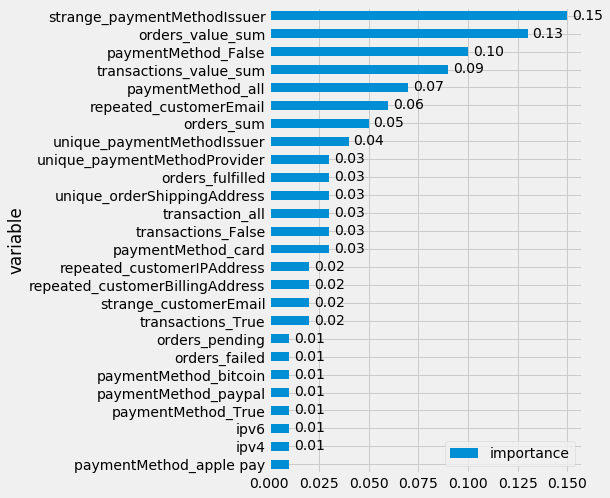

In [499]:
ax = importances_df.plot.barh(figsize=(5,8))
for p in ax.patches:
    ax.annotate("%.2f" % p.get_width(), (p.get_x() + p.get_width(), p.get_y()-0.5), xytext=(5, 10), textcoords='offset points')

### remove small-importance variables

In [694]:
importances_df['importance'] = importances_df['importance'].astype(float)
important_variables = importances_df[importances_df['importance'] > 0.03].reset_index()['variable'].tolist()

In [695]:
# Use numpy to convert to arrays
import numpy as np
# Labels are the values we want to predict
labels = np.array(features_df_clean['fraudulent'])
# Remove the labels from the features
# axis 1 refers to the columns
features = features_df_clean.loc[:, important_variables]
# Saving feature names for later use
feature_list = list(features.columns)
# Convert to numpy array
features = np.array(features)

In [696]:
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets
train_x, test_x, train_y, test_y = train_test_split(features, labels, 
                                                    test_size = 0.25, random_state = 23)

In [697]:
# Import the model we are using
from sklearn.ensemble import RandomForestClassifier
# Instantiate model with 1000 decision trees
rf = RandomForestClassifier(n_estimators = 1000, random_state = 23)
# Train the model on training data
rf.fit(train_x, train_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=23, verbose=0,
                       warm_start=False)

In [698]:
# Use the forest's predict method on the test data
predictions = rf.predict(test_x)

In [699]:
from sklearn.metrics import accuracy_score, confusion_matrix
accuracy_score(train_y, rf.predict(train_x))

1.0

In [700]:
accuracy_score(test_y, predictions)

0.8055555555555556

In [701]:
confusion_matrix(test_y, predictions)

array([[18,  1],
       [ 6, 11]])

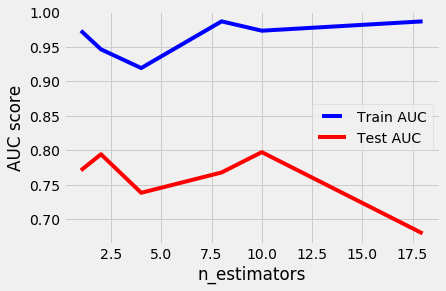

In [703]:
n_estimators = [1, 2, 4, 8, 10, 18]
train_results = []
test_results = []
for estimator in n_estimators:
    rf = RandomForestClassifier(n_estimators=estimator, n_jobs=-1)
    rf.fit(train_x, train_y)
    train_pred = rf.predict(train_x)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(train_y, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = rf.predict(test_x)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(test_y, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(n_estimators, train_results, 'b', label='Train AUC')
line2, = plt.plot(n_estimators, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('n_estimators')
plt.show()


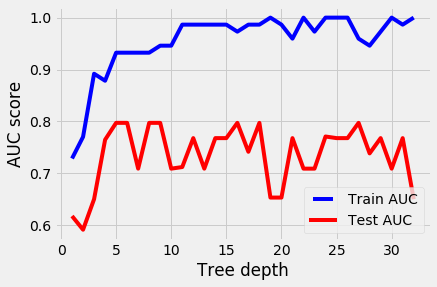

In [638]:
import warnings, matplotlib
warnings.filterwarnings("ignore")

max_depths = np.linspace(1, 32, 32, endpoint=True)
train_results = []
test_results = []
for max_depth in max_depths:
    rf = RandomForestClassifier(max_depth=max_depth, n_jobs=-1)
    rf.fit(train_x, train_y)
    train_pred = rf.predict(train_x)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(train_y, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = rf.predict(test_x)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(test_y, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results, 'b', label='Train AUC')
line2, = plt.plot(max_depths, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('Tree depth')
plt.show()

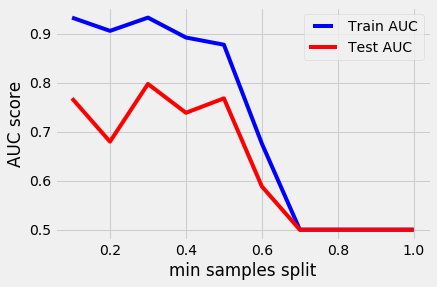

In [639]:
min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)
train_results = []
test_results = []
for min_samples_split in min_samples_splits:
    rf = RandomForestClassifier(min_samples_split=min_samples_split)
    rf.fit(train_x, train_y)
    train_pred = rf.predict(train_x)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(train_y, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = rf.predict(test_x)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(test_y, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(min_samples_splits, train_results, 'b', label="Train AUC")
line2, = plt.plot(min_samples_splits, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC score")
plt.xlabel("min samples split")
plt.show()

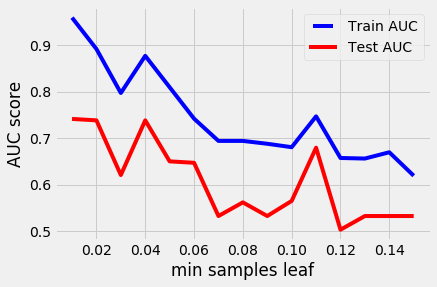

In [640]:
min_samples_leafs = np.linspace(0.01, 0.15, 15, endpoint=True)
train_results = []
test_results = []
for min_samples_leaf in min_samples_leafs:
    rf = RandomForestClassifier(min_samples_leaf=min_samples_leaf)
    rf.fit(train_x, train_y)
    train_pred = rf.predict(train_x)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(train_y, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = rf.predict(test_x)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(test_y, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(min_samples_leafs, train_results, 'b', label='Train AUC')
line2, = plt.plot(min_samples_leafs, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('min samples leaf')
plt.show()

In [682]:
# Import the model we are using
from sklearn.ensemble import RandomForestClassifier
# Instantiate model with 1000 decision trees
rf = RandomForestClassifier(n_estimators = 20, random_state = 23, max_depth=5)
# Train the model on training data
rf.fit(train_x, train_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=5, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=20,
                       n_jobs=None, oob_score=False, random_state=23, verbose=0,
                       warm_start=False)

In [683]:
# Use the forest's predict method on the test data
predictions = rf.predict(test_x)

In [684]:
from sklearn.metrics import accuracy_score, confusion_matrix
accuracy_score(train_y, rf.predict(train_x))

0.9428571428571428

In [685]:
accuracy_score(test_y, predictions)

0.75

In [686]:
confusion_matrix(test_y, predictions)

array([[18,  1],
       [ 8,  9]])

## Logistic Regression

In [407]:
from sklearn.linear_model import LogisticRegression
logmodel = LogisticRegression()
logmodel.fit(train_x, train_y)

/home/azawalich/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [408]:
from sklearn.metrics import classification_report

In [409]:
print(classification_report(test_y, predictions))

              precision    recall  f1-score   support

       False       0.72      0.95      0.82        19
        True       0.91      0.59      0.71        17

    accuracy                           0.78        36
   macro avg       0.81      0.77      0.77        36
weighted avg       0.81      0.78      0.77        36



## SVM

In [410]:
from sklearn import svm
clf = svm.SVC(gamma=0.001, C=100.)
clf.fit(train_x, train_y)

SVC(C=100.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [411]:
clf_predictions = clf.predict(test_x)
print("Accuracy: {}%".format(clf.score(test_x, test_y) * 100 ))

Accuracy: 63.888888888888886%
